# Evaluation of Simulation Models

This notebook studies various properties of the simulation models used in `covid19 outbreak simulator`.

In [1]:
from matplotlib import pyplot
import numpy as np
import pandas as pd
import os

from argparse import Namespace
from covid19_outbreak_simulator.model import Model, Params
from covid19_outbreak_simulator.population import Individual

model = 'piecewise'
params = Params(
    Namespace(
        interval=1/24,
        popsize=['64'],
        infectors=[],
        symptomatic_r0=None,
        asymptomatic_r0=None,
        incubation_period=None,
        susceptibility=None,
        prop_asym_carriers=None,
        symptomatic_transmissibility_model = [model],
        asymptomatic_transmissibility_model = [model],
    )
)
model = Model(params)

## Distribution of asymptomatic carriers

In [2]:
avg_asym_carriers = 0
N = 1000
for i in range(N):
    model.draw_prop_asym_carriers()
    avg_asym_carriers += sum([model.draw_is_asymptomatic() for i in range(1000)])/1000

avg_asym_carriers /= N

print(f'Average asymptomatic carriers is {avg_asym_carriers * 100:.2f}%')
    

Average asymptomatic carriers is 24.92%


## Distribution of incubation period

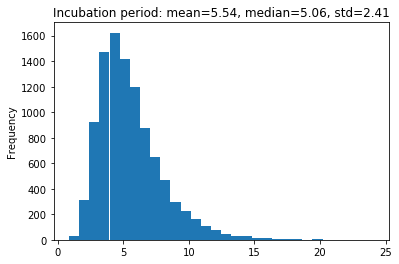

In [3]:
model.params.set('prop_asym_carriers', 'loc', 0)
model.params.set('prop_asym_carriers', 'scale', 0)

ips = pd.Series([model.draw_random_incubation_period() for x in range(10000)])

ips.plot(kind='hist', bins=30, 
         title=f'Incubation period: mean={ips.mean():.2f}, median={ips.median():.2f}, std={ips.std():.2f}')

## Distribution of production number

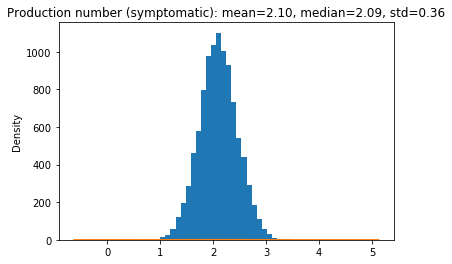

In [4]:
# thoretical distribution

sr0 = pd.Series([model.draw_random_r0(symptomatic=True) for x in range(10000)])
sr0.plot.hist( bins=30,
         title=f'Production number (symptomatic): mean={sr0.mean():.2f}, median={sr0.median():.2f}, std={sr0.std():.2f}')
sr0.plot.density()

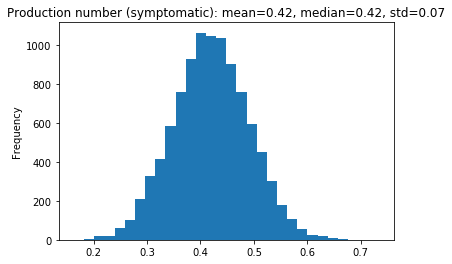

In [5]:

asr0 = pd.Series([model.draw_random_r0(symptomatic=False) for x in range(10000)])
asr0.plot.hist( bins=30,
         title=f'Production number (symptomatic): mean={asr0.mean():.2f}, median={asr0.median():.2f}, std={asr0.std():.2f}')


## Observed production number

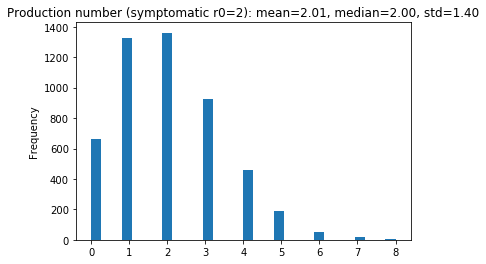

In [6]:
import os

model.params.set('prop_asym_carriers', 'loc', 0)
model.params.set('prop_asym_carriers', 'scale', 0)

infections = []
r0 = []
with open(os.devnull, 'w') as logger:
    logger.id = 1
    model.draw_prop_asym_carriers()
    model.params.set('symptomatic_r0', 'loc', 2)
    model.params.set('symptomatic_r0', 'scale', 0)
    for i in range(5000):
        ind = Individual(id='0', susceptibility=1, model=model, logger=logger)
        evts = ind.symptomatic_infect(time=0, by=None,
                                     handle_symptomatic=['keep'])
        r0.append(ind.r0)
        # print(', '.join(x.action.name for x in evts))
        infect_evts = [evt for evt in evts if evt.action.name == 'INFECTION']
        infections.append(len(infect_evts))

ifn = pd.Series(infections)
ifn.plot.hist( bins=30,
         title=f'Production number (symptomatic r0=2): mean={ifn.mean():.2f}, median={ifn.median():.2f}, std={ifn.std():.2f}')

#sr0 = pd.Series(r0)
#sr0.plot.hist()


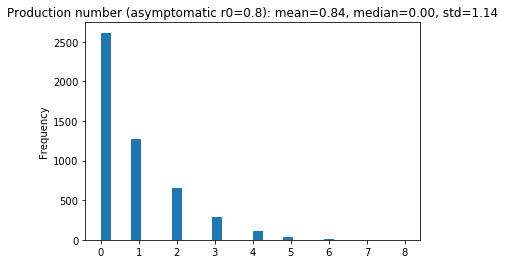

In [7]:
import os

model.params.set('prop_asym_carriers', 'loc', 1.0)
model.params.set('prop_asym_carriers', 'scale', 0)

infections = []
r0 = []
with open(os.devnull, 'w') as logger:
    logger.id = 1
    model.draw_prop_asym_carriers()
    model.params.set('asymptomatic_r0', 'loc', 0.8)
    model.params.set('asymptomatic_r0', 'scale', 0.8)    
    for i in range(5000):
        ind = Individual(id='0', susceptibility=1, model=model, logger=logger)
        evts = ind.asymptomatic_infect(time=0, by=None,
                                     handle_symptomatic=['keep'])
        r0.append(ind.r0)
        # print(', '.join(x.action.name for x in evts))
        infect_evts = [evt for evt in evts if evt.action.name == 'INFECTION']
        infections.append(len(infect_evts))

ifn = pd.Series(infections)
ifn.plot.hist( bins=30,
         title=f'Production number (asymptomatic r0=0.8): mean={ifn.mean():.2f}, median={ifn.median():.2f}, std={ifn.std():.2f}')

#asr0 = pd.Series(r0)
#asr0.plot.hist()


### Communicable period 

In [48]:
import matplotlib.pyplot as plt

model.params.set('prop_asym_carriers', 'loc', 0)
model.params.set('prop_asym_carriers', 'scale', 0)

infections = []
cp = []
du = []
with open(os.devnull, 'w') as logger:
    logger.id = 1
    model.draw_prop_asym_carriers()
    model.params.set('symptomatic_r0', 'loc', 2.1)
    model.params.set('symptomatic_r0', 'quantile_2.5', 1.4)
    for i in range(10000):
        ind = Individual(id='0', susceptibility=1, model=model, logger=logger)
        evts = ind.symptomatic_infect(time=0, by=None,
                                     handle_symptomatic=['keep'])
        cp.append(ind.communicable_period())
        du.append(ind.total_duration())

#plt.subplot(211)

model.params.set('prop_asym_carriers', 'loc', 1)
model.params.set('prop_asym_carriers', 'scale', 0)

infections = []
acp = []
adu = []
with open(os.devnull, 'w') as logger:
    logger.id = 1
    model.draw_prop_asym_carriers()
    model.params.set('asymptomatic_r0', 'loc', 2.1/5)
    model.params.set('asymptomatic_r0', 'quantile_2.5', 1.4/5)
    for i in range(10000):
        ind = Individual(id='0', susceptibility=1, model=model, logger=logger)
        evts = ind.asymptomatic_infect(time=0, by=None,
                                     handle_symptomatic=['keep'])
        acp.append(ind.communicable_period())
        adu.append(ind.total_duration())



Text(5.302095833333333, 0.35, 'mean=5.3')

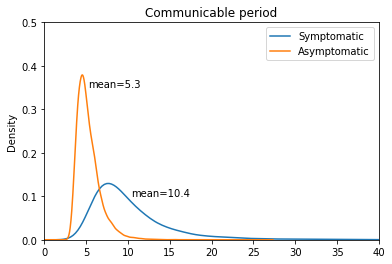

In [52]:
CP_all = pd.DataFrame( {
    'Symptomatic': cp,
    'Asymptomatic': acp
}
) 
mean_cp = pd.Series(cp).mean()
mean_acp = pd.Series(acp).mean()

CP_all.plot.density(
         title=f'Communicable period', xlim=[0, 40], ylim=[0, 0.5])

plt.text(mean_cp, 0.10, f'mean={mean_cp:.1f}')
plt.text(mean_acp, 0.35, f'mean={mean_acp:.1f}')

Text(5.916625, 0.35, 'mean=5.9')

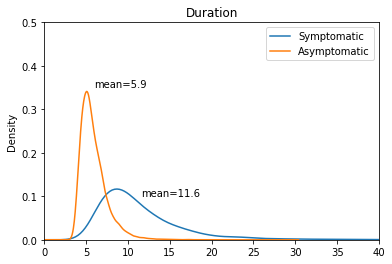

In [51]:
DURATION_all = pd.DataFrame( {
    'Symptomatic': du,
    'Asymptomatic': adu
}
)        
mean_du = pd.Series(du).mean()
mean_adu = pd.Series(adu).mean()


DURATION_all.plot.density(
         title=f'Duration', xlim=[0, 40], ylim=[0, 0.5])
plt.text(mean_du, 0.10, f'mean={mean_du:.1f}')
plt.text(mean_adu, 0.35, f'mean={mean_adu:.1f}')

## Serial Interval 

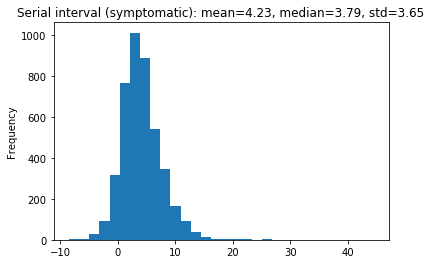

In [53]:
model.params.set('prop_asym_carriers', 'loc', 0)
model.params.set('prop_asym_carriers', 'scale', 0)

si = []
gt = []

with open(os.devnull, 'w') as logger:
    logger.id = 1
    model.draw_prop_asym_carriers()
    for i in range(5000):
        ind = Individual(id='0', susceptibility=1, model=model, logger=logger)
        evts = ind.symptomatic_infect(time=0, by=None,
                                     handle_symptomatic=['keep'])
        for evt in [x for x in evts if x.action.name == 'INFECTION']:
            gt.append(evt.time)
            si.append(evt.time + ind.model.draw_random_incubation_period() - ind.incubation_period)
            break

ssi = pd.Series(si)
ssi.plot.hist( bins=30,
         title=f'Serial interval (symptomatic): mean={ssi.mean():.2f}, median={ssi.median():.2f}, std={ssi.std():.2f}')


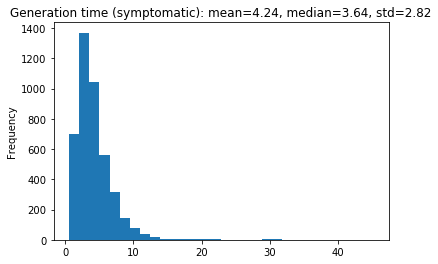

In [54]:
sgt = pd.Series(gt)
sgt.plot.hist( bins=30,
         title=f'Generation time (symptomatic): mean={sgt.mean():.2f}, median={sgt.median():.2f}, std={sgt.std():.2f}')


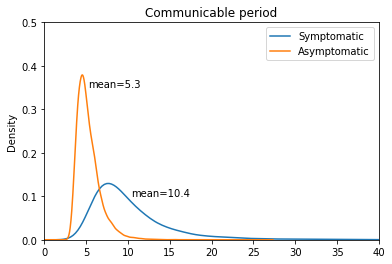

In [96]:
CP_all = pd.DataFrame( {
    'Symptomatic': cp,
    'Asymptomatic': acp
}
) 
mean_cp = pd.Series(cp).mean()
mean_acp = pd.Series(acp).mean()

#plt.subplot(122)

cp_plt = CP_all.plot.density(
         title=f'Communicable period', xlim=[0, 40], ylim=[0, 0.5])

plt.text(mean_cp, 0.10, f'mean={mean_cp:.1f}')
plt.text(mean_acp, 0.35, f'mean={mean_acp:.1f}')

plt.savefig('communicable_period.pdf')

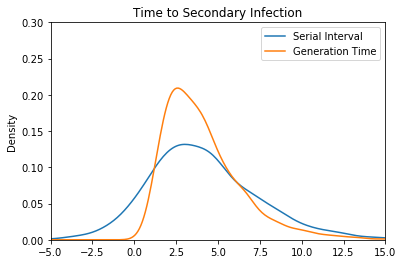

In [97]:
GC_all = pd.DataFrame(
{
    'Serial Interval': si,
    'Generation Time': gt
}    
)
mean_si = pd.Series(si).mean()
mean_gt = pd.Series(gt).mean()

gc_plt = GC_all.plot.density('scott',
         title=f'Time to Secondary Infection', xlim=[-5, 15], ylim=[0, 0.3])

#plt.text(mean_si, 0.10, f'mean={mean_si:.1f}')
#plt.plot([mean_si, mean_si], [0, 0.20], color='green')
# plt.text(mean_gt, 0.20, f'mean={mean_gt:.1f}')
plt.savefig('Secondary_infection.pdf')

## Transmissibility and viral load curves

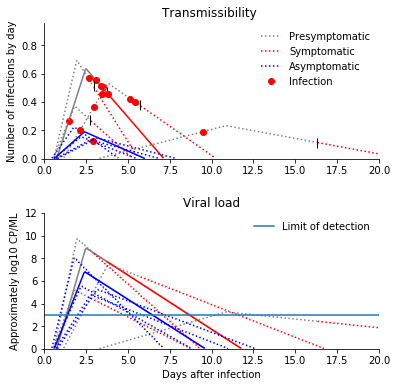

In [12]:
import os
import matplotlib.pyplot as plt

model.params.set('prop_asym_carriers', 'loc', 0)
model.params.set('prop_asym_carriers', 'scale', 0)

infections = []
r0 = []

fig, (ax1, ax2) = plt.subplots(2, figsize=[6, 6])
ax1.set_title('Transmissibility ')
ax2.set_title('Viral load')


with open(os.devnull, 'w') as logger:
    logger.id = 1
    model.draw_prop_asym_carriers()
    for i in range(5):
        ind = Individual(id='0', susceptibility=1, model=model, logger=logger)
        evts = ind.symptomatic_infect(time=0, by=None,
                                     handle_symptomatic=['keep'])
        x = np.linspace(0, 20, 20*24)

        y = [ind.transmissibility(t)*24 for t in x]
        
        # incubation
        x_bi = [t for (t,v) in zip(x,y) if t < ind.incubation_period and v > 0]
        y_bi = [v for (t,v) in zip(x,y) if t < ind.incubation_period and v > 0]
        
        x_ai = [t for (t,v) in zip(x,y) if t >= ind.incubation_period and v > 0]
        y_ai = [v for (t,v) in zip(x,y) if t >= ind.incubation_period and v > 0]
        
        line_presym, = ax1.plot(x_bi, y_bi, linestyle=':' if i > 0 else '-', color='gray',
                           label='Presymptomatic')
        line_sym, = ax1.plot(x_ai, y_ai, linestyle=':' if i > 0 else '-', color='red',
                            label='Symptomatic')

        # incubation point
        ax1.plot(ind.incubation_period, ind.transmissibility(ind.incubation_period) * 24,
                color='black', markersize=10, marker='|')
       
        # infection event
        it = [x.time for x in evts if x.action.name == 'INFECTION']
        ity = [ind.transmissibility(t)*24 for t in it]
        line_infection, = ax1.plot(it, ity, 'o', color='red', label='Infection')
        
        y = [ind.viral_load(t) for t in x]        
        x_bi = [t for (t,v) in zip(x,y) if t < ind.incubation_period and v > 0]
        y_bi = [v for (t,v) in zip(x,y) if t < ind.incubation_period and v > 0]
        
        x_ai = [t for (t,v) in zip(x,y) if t >= ind.incubation_period and v > 0]
        y_ai = [v for (t,v) in zip(x,y) if t >= ind.incubation_period and v > 0]
        
        ax2.plot(x_bi, y_bi, linestyle=':' if i > 0 else '-', color='gray',
                           label='Presymptomatic')
        ax2.plot(x_ai, y_ai, linestyle=':' if i > 0 else '-', color='red',
                            label='Symptomatic')

        
model.params.set('prop_asym_carriers', 'loc', 1)
model.params.set('prop_asym_carriers', 'scale', 0)

infections = []
r0 = []

with open(os.devnull, 'w') as logger:
    logger.id = 1
    model.draw_prop_asym_carriers()
    for i in range(5):
        ind = Individual(id='0', susceptibility=1, model=model, logger=logger)
        evts = ind.asymptomatic_infect(time=0, by=None,
                                     handle_symptomatic=['keep'])
        x = np.linspace(0, 20, 20*24)
        y = [ind.transmissibility(t)*24 for t in x]
        
        x_p = [t for (t,v) in zip(x,y) if v > 0]
        y_p = [v for (t,v) in zip(x,y) if v > 0]
        
        
        line_asym, = ax1.plot(x_p,y_p, linestyle=':' if i > 0 else '-', color='blue', label='Asymptomatic')
        
        # infection
        it = [x.time for x in evts if x.action.name == 'INFECTION']
        ity = [ind.transmissibility(t)*24 for t in it]
        ax1.plot(it, ity, 'o', color='red')

        y = [ind.viral_load(t) for t in x]
        x_p = [t for (t,v) in zip(x,y) if v > 0]
        y_p = [v for (t,v) in zip(x,y) if v > 0]
        ax2.plot(x_p, y_p, linestyle=':' if i > 0 else '-', color='blue')
        
line_lod, = ax2.plot([0, 20], [3, 3], label='Limit of detection') 

ax1.legend(handles=[line_presym, line_sym, line_asym, line_infection], frameon=False)
ax2.legend(handles=[line_lod], frameon=False)

ax1.set_xlim(0, 20)
ax1.set_ylim(0, 0.04*24)
ax2.set_xlim(0, 20)
ax2.set_ylim(0, 12)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.set_ylabel('Number of infections by day')
ax2.set_ylabel('Approximately log10 CP/ML')

ax2.set_xlabel('Days after infection')
plt.subplots_adjust(hspace=0.4)
plt.show()
                

## Test sensibility



In [13]:
# from covid19_outbreak_simulator.cli import main

# main('''--popsize 5000 --rep 1
#     --symptomatic-transmissibility-model piecewise
#     --asymptomatic-transmissibility-model piecewise
#     --handle-symptomatic keep
#     --stop-if t>14   --track-events PLUGIN END   
#     --logfile test.log   --plugin init --incidence-rate 1  --leadtime any 
#     --plugin quarantine --at 0 --duration 14 --target all --proportion 1   
#     --plugin testing   --interval 1 --proportion 1
#     --turnaround-time 0
#     --handle-positive keep --sensitivity 0.9 0.0002  --specificity 1
#   '''.split())

In [14]:
import pandas as pd

res = pd.read_csv('test.log', sep='\t')
res = res[(res['event'] == 'PLUGIN') & res['params'].str.startswith('name=testing')]

In [15]:
def get_test_stats(params):
    n_infected = params.split('n_infected=')[1].split(',')[0]
    n_uninfected = params.split('n_uninfected=')[1].split(',')[0]
    n_recovered = params.split('n_recovered=')[1].split(',')[0]    
    n_false_negative = params.split('n_false_negative=')[1].split(',')[0]
    return n_infected, n_uninfected, n_recovered, n_false_negative

res['params'].apply(get_test_stats)

2         (5000, 0, 0, 929)
3       (4402, 0, 598, 563)
4      (3830, 0, 1170, 489)
5      (3247, 0, 1753, 576)
6      (2653, 0, 2347, 799)
7     (2127, 0, 2873, 1114)
8     (1671, 0, 3329, 1569)
9     (1275, 0, 3725, 2015)
10     (968, 0, 4032, 2462)
11     (711, 0, 4289, 2870)
12     (545, 0, 4455, 3152)
13     (421, 0, 4579, 3472)
14     (333, 0, 4667, 3749)
15     (242, 0, 4758, 3968)
16     (185, 0, 4815, 4146)
Name: params, dtype: object

In [16]:
res

,id,time,event,target,params
2,1,0.0,PLUGIN,.,"name=testing,n_tested=5000,n_infected=5000,n_u..."
3,1,1.0,PLUGIN,.,"name=testing,n_tested=5000,n_infected=4402,n_u..."
4,1,2.0,PLUGIN,.,"name=testing,n_tested=5000,n_infected=3830,n_u..."
5,1,3.0,PLUGIN,.,"name=testing,n_tested=5000,n_infected=3247,n_u..."
6,1,4.0,PLUGIN,.,"name=testing,n_tested=5000,n_infected=2653,n_u..."
7,1,5.0,PLUGIN,.,"name=testing,n_tested=5000,n_infected=2127,n_u..."
8,1,6.0,PLUGIN,.,"name=testing,n_tested=5000,n_infected=1671,n_u..."
9,1,7.0,PLUGIN,.,"name=testing,n_tested=5000,n_infected=1275,n_u..."
10,1,8.0,PLUGIN,.,"name=testing,n_tested=5000,n_infected=968,n_un..."
11,1,9.0,PLUGIN,.,"name=testing,n_tested=5000,n_infected=711,n_un..."
